# Group Assignment 3: Cleaned Up Map of Clean Energy Power Plants in California

Author: Suzanne Caflisch

This notebook cleans up my midterm notebook, which explored data sets and methods for the final project. It includes only the bare minimum data necessary to produce the maps I needed to make, along with brief explanations of the necessity of each step. I have also attempted to explain why the data is important for addressing my research question. Additionally, please note that loops are present in the workbook.

As a reminder, our overall project is researching and mapping the availability and quality of existing “dirty” energy jobs versus green jobs across California. To that end, our research will answer the following questions:

1. Where in California are existing fossil fuel/"dirty" energy jobs located relative to green jobs?
2. What are the demographics in the regions where green jobs are located relative to fossil fuel jobs?

Evaluated together, these research questions will provide a visualization of geographic accessibility of clean energy jobs versus fossil fuel jobs for disadvantaged communities. Disadvantaged communities are defined as the top 25% scoring areas from CalEnviroScreen, which considers socioeconomic, public health and environmental hazard criteria.

In [1]:
import geopandas as gpd
import pandas as pd
import contextily as ctx
import matplotlib.pyplot as plt
clean = gpd.read_file('NAICSclean.csv')

I imported the necessary datasets and libraries to work with in order to produce maps of clean energy power plants in the state of California.

In [2]:
clean = clean.drop([0])

I dropped the first cell (containing headings) from the data set.

In [3]:
desired_columns = ['GEO_ID', 'NAME', 'NAICS2017_LABEL','EMP', 'geometry']
clean_trimmed = clean[desired_columns].copy()
clean_trimmed.columns = ['GEO_ID', 'NAME', 'JOBTYPE', 'EMP', 'geometry']

Dropping unnessecary columns, and renamed the NAICS2017_LABEL column "JOBTYPE".

In [5]:
clean_trimmed2 = clean_trimmed[clean_trimmed.EMP != 'N']

I removed all of the rows where employment is N (for "null").

In [6]:
clean_trimmed2['EMP'] = clean_trimmed2['EMP'].astype(str).astype(int)

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


I changed "EMP" value to an integer. 

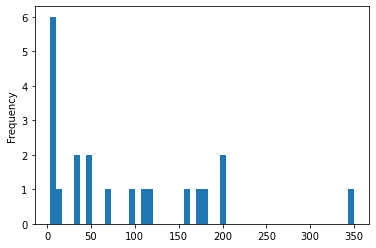

In [7]:
clean_trimmed2['EMP'].plot.hist(bins=50)

This histogram shows the number of clean energy jobs per county. 

Analysis: note the wide distribution of the number of jobs by county. It looks like one county has around 350, four counties have around 200 jobs, and the rest of the counties fall below ~175 jobs. This indicates that the number of clean energy jobs are highly stratified across the counties of California. Also, the numbers themselves are quite low! The highest number of jobs is still only 350. This will be interesting to compare to fossil fuel job numbers later on in the project.

In [8]:
counties = gpd.read_file('CA_Counties_TIGER2016.shp')
for index, row in clean_trimmed2.iterrows():
    geomid = row['GEO_ID']
    last_digits = geomid[-5:]
    countyrow = counties[counties.GEOID == last_digits]
    clean_trimmed2.loc[[index], 'geometry'] = countyrow['geometry'].values

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In order to add geometry data to my clean energy dataset, I imported a new dataset, "counties", which pulls data from the CA Counties Data set (which has geometry data in it). Then I created a for loop to iterate through each row.

In [9]:
clean_counties = clean_trimmed2[['NAME', 'geometry', 'EMP']]
clean_counties['EMP'] = clean_counties["EMP"].astype(int)
clean_counties = clean_counties.dissolve(by= 'NAME', aggfunc= 'sum')

I created a new geopandas dataframe with just NAME, geometry, and EMP columns. Then I dissolved the rows and summed employment per county.

In [10]:
job_types = clean_trimmed2.JOBTYPE.unique()
for job in job_types:
    clean_counties[job] = 0

I created a new data frame job_types, which allowed me to add back in the individual JOBTYPE employment counts by creating new columns for each value in JOBTYPE. The clean_trimmed2.JOBTYPE.unique() function pulls up the unique JOBTYPE values in the clean_trimmed2 dataframe. I then created a "for" loop that creates a new column in clean_counties called jobs that gives it a default value 0 for all rows.

In [11]:
for index, row in clean_counties.iterrows():
    countyrows = clean_trimmed2[clean_trimmed2['NAME'] == index]
   
    for trimmed_index, trimmed_row in countyrows.iterrows():
        row[trimmed_row.JOBTYPE] = trimmed_row.EMP
        clean_counties.loc[[index], trimmed_row.JOBTYPE] = trimmed_row.EMP    
    
    

I created a "for" loop to iterate through each row and add the EMP values to each job type column. I defined a new variable that returns a dataframe which includes only the rows in clean_trimmed2 equal to a particular name in the clean_counties dataframe.

I then created another "for" loop (within the first loop), which says that for a new variable trimmed_index, to iterate through each row in the countrows datagrame we created above. Where the value in the clean_counties row is equal to the value of clean_trimmed2 JOBTYPE, we set equal to the employment value for that JOBTYPE in the clean_trimmed2 dataframe.

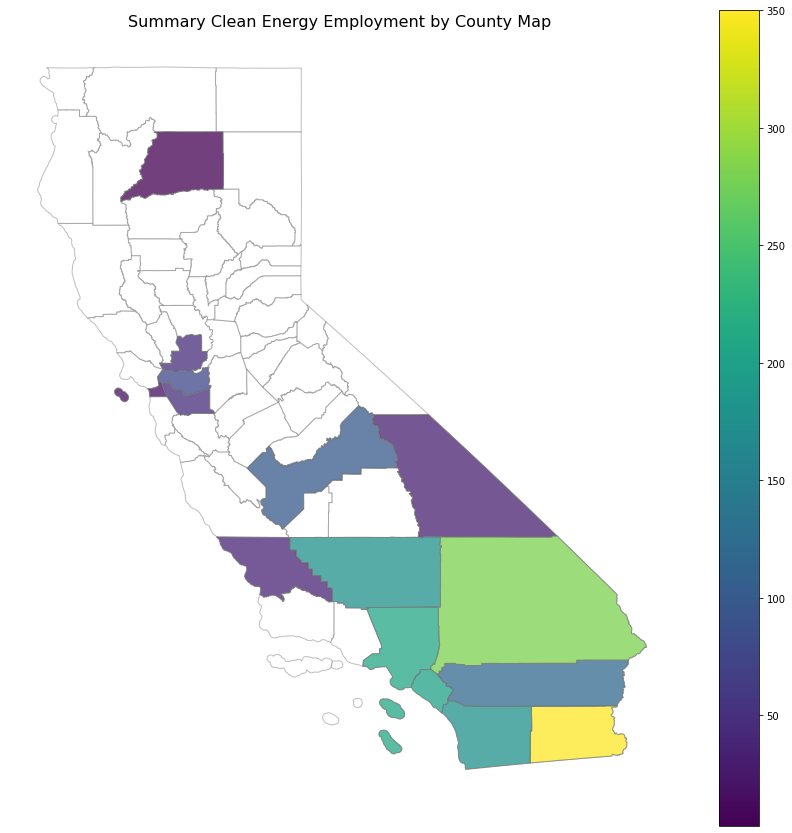

In [12]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.axis('off')
ax.set_title('Summary Clean Energy Employment by County Map ',fontsize=16)
counties.plot(alpha=0.5, color = 'white', edgecolor ='grey', ax=ax)
clean_counties.plot(column = 'EMP',
            alpha=0.75, 
            legend = True, 
            linewidth = 1, 
            edgecolor='grey',
            figsize=(12,10),
            ax=ax)

I mapped clean energy jobs data by county. White counties have no clean energy jobs. The lightest color counties have the highest number of clean energy jobs. I set the boundaries to grey for aesthetic purposes. 

Analysis: we can see that most clean energy jobs are concentrated in Southern California, with only one county in Northern California showing any clean energy jobs at all. This could be because of deliberate policies that attracted these industries to the region, or other historic factors that are bringing these plants to SoCal.

In [13]:
gdf = gpd.read_file('CES3June2018Update.shp')
columns_to_keep = ['tract', 'pop2010', 'California', 'ZIP', 'City', 'Longitude', 'Latitude', 'CIscore', 'CIscoreP', 'edu', 'eduP', 'pov', 'povP', 'unemp', 'unempP', 'Pop_11_64_', 'Elderly_ov', 'Hispanic_p', 'White_pct', 'African_Am', 'Native_Ame', 'Asian_Amer', 'Other_pct', 'geometry']
gdf = gdf[columns_to_keep]

I imported a new dataframe "gdf" and trimmed it to only desirable columns.

In [14]:
gdf_sortbyCES = gdf.sort_values(by='CIscore', ascending = False)

I sorted the data by CES score by creating a new dataframe.

In [15]:
clean_counties = clean_counties.set_crs('epsg:3857')
cleanjobsreproject = clean_counties.to_crs('epsg:3310')

I created a new variable that sets the clean_counties crs to the counties crs. I then converted the clean_counties to the same crs as the gdf dataframe.

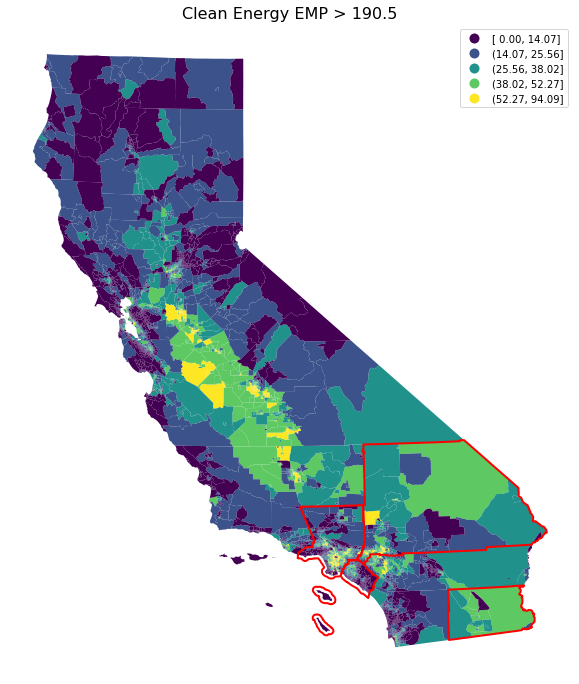

In [16]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.axis('off')
ax.set_title('Clean Energy EMP > 190.5',fontsize=16)
gdf_sortbyCES.plot(figsize=(12,12),
                   column='CIscore',
                   legend=True,
                   scheme='NaturalBreaks',
                  ax=ax)
cleanjobsreproject[cleanjobsreproject['EMP'] > 190.5].plot(ax=ax,edgecolor='red',color='none',linewidth=2)

I overlayed fossil fuel jobs and CalEnviroScreen data to produce this map of the counties with clean energy job counts in the upper quartile of all counties in California. The four counties in the upper quartile of highest number of clean energy jobs are Los Angeles County, San Bernadino County, Imperial County, and Orange County (as plotted here).

Analysis: a preliminary glance shows not a lot of correlations between CES vulnerability and the location of clean energy power plants. The Central Valley appears to have the highest concentration of vulnerability, with some other pockets in San Bernadino and Los Angeles (which are both in the upper quartile of clean energy jobs in CA). The data visualization raises questions about the 